In [8]:
import pandas as pd
import numpy as np
import os
import sys
import torch
import yaml
from matplotlib import pyplot as plt

sys.path.append('/home/anna.jungbluth/InstrumentToInstrument/')

from itipy.iti import ITIModule
from itipy.data.geo_datasets import GeoDataset
from itipy.data.geo_editor import BandSelectionEditor, NanMaskEditor, CoordNormEditor, NanDictEditor, RadUnitEditor, ToTensorEditor, StackDictEditor, MeanStdNormEditor, MinMaxNormEditor, Rotate180Editor
from itipy.data.geo_utils import get_split, get_list_filenames, normalize, calculate_norm_from_metrics

In [ ]:
msg_path = '/home/data/msg'
goes_path = '/home/data/goes'

config_path = '/home/anna.jungbluth/models/MSG_to_GOES-infrared-1band/config/msg_to_goes.yaml'

In [5]:
config = yaml.safe_load(open(config_path, 'r'))

In [14]:
splits_dict = { 
    "train": {
        "years": [2020], 
        "months": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
        "days": list(range(1, 25))
        },
    "val": {
        "years": [2020],
        "months": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
        "days": list(range(25, 32))
        },
}

fov_radius = config['data']['fov_radius'] if 'fov_radius' in config['data'] else 0.5

norm_config = config['normalization']
msg_norm = calculate_norm_from_metrics(norm_config['A_norm_dir'], split_dict=splits_dict['train'])
goes_norm = calculate_norm_from_metrics(norm_config['B_norm_dir'], split_dict=splits_dict['train'])

In [15]:
msg_bands = config['data']['A_bands']
msg_editors = [
    BandSelectionEditor(target_bands=msg_bands),
    NanDictEditor(key="data", fill_value=0), # Replaces NaNs in data
    Rotate180Editor(key="data"), # Rotate 180 degrees to align north to top of image
    MinMaxNormEditor(norm_dict=msg_norm, key="data"),
    StackDictEditor(allowed_keys = ['data']),
    ToTensorEditor(),
]

goes_bands = config['data']['B_bands']
goes_editors = [
    BandSelectionEditor(target_bands=goes_bands),
    NanDictEditor(key="data", fill_value=0), # Replaces NaNs in data
    MinMaxNormEditor(norm_dict=goes_norm, key="data"),
    StackDictEditor(allowed_keys = ['data']),
    ToTensorEditor(),
]

In [16]:
msg_patch_size = (256, 256)
goes_patch_size = (256, 256)

In [17]:
msg_dataset = GeoDataset(
    data_dir=msg_path,
    editors=msg_editors,
    splits_dict=splits_dict['train'],
    fov_radius=fov_radius,
    load_coords=False,
    load_cloudmask=False,
    patch_size=msg_patch_size,
)

msg_valid = GeoDataset(
    data_dir=msg_path,
    editors=msg_editors,
    splits_dict=splits_dict['val'],
    fov_radius=fov_radius,
    load_coords=False,
    load_cloudmask=False,
    patch_size=msg_patch_size,
)

goes_dataset = GeoDataset(
    data_dir=goes_path,
    editors=goes_editors,
    splits_dict=splits_dict['train'],
    fov_radius=fov_radius,
    load_coords=False,
    load_cloudmask=False,
    patch_size=goes_patch_size,
)

goes_valid = GeoDataset(
    data_dir=goes_path,
    editors=goes_editors,
    splits_dict=splits_dict['val'],
    fov_radius=fov_radius, 
    load_coords=False,
    load_cloudmask=False,
    patch_size=goes_patch_size,
)

In [23]:
checkpoint_path = '/home/anna.jungbluth/models/MSG_to_GOES-infrared-1band/checkpoints/checkpoint_400000.pt'
model = torch.load(checkpoint_path, weights_only=False, map_location='cpu')
model_ab = model['gen_ab']
model_ab.eval()
model_ba = model['gen_ba']
model_ba.eval()
noise_estimator = model['noise_est'];

In [24]:
sample_msg = msg_valid.sample(4)
sample_goes = goes_valid.sample(4)

In [25]:
output_ab = model_ab(torch.tensor(sample_msg))

noise = noise_estimator(torch.tensor(sample_goes))
output_ba = model_ba(torch.tensor(sample_goes), noise=noise)

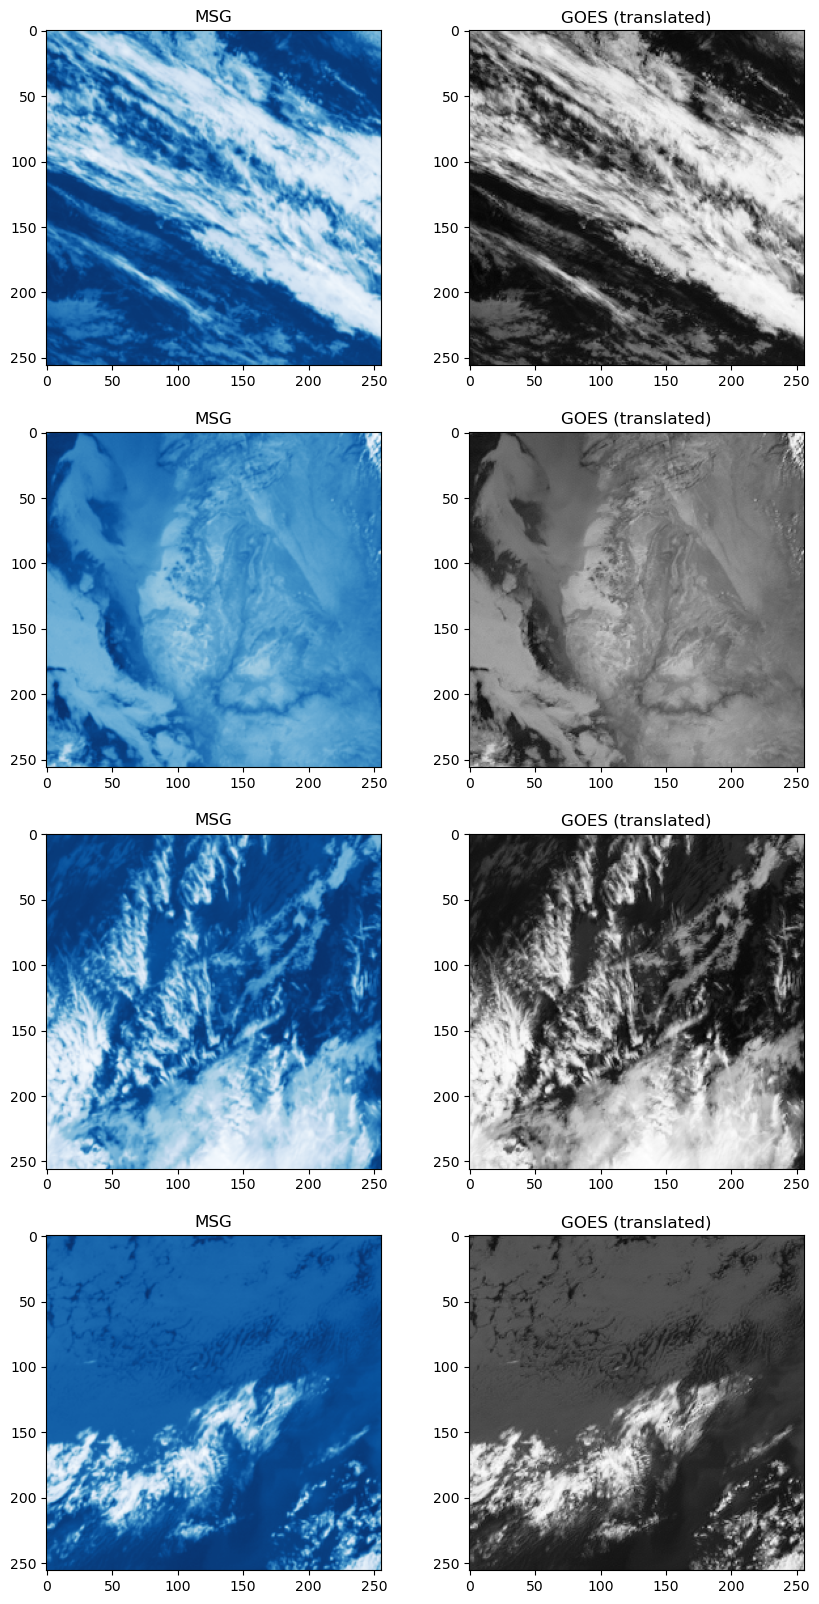

In [28]:
rows = 4
cols = 2
plt.subplots(rows, cols, figsize=(10, 20))

for i in range(rows):
    # MSG
    plt.subplot(rows, cols, i*cols + 1)
    plt.imshow(sample_msg[i][0], cmap='Blues')
    plt.title('MSG')

    # GOES
    plt.subplot(rows, cols, i*cols + 2)
    plt.imshow(output_ab[i][0].detach().numpy(), cmap='Greys')
    plt.title('GOES (translated)')